# Experimentación con Bloques Convolucionales

Este notebook explora los bloques fundamentales de la arquitectura U-Net:
- **ConvBlock**: Conv2d + BatchNorm2d + ReLU
- **DoubleConv**: Dos ConvBlocks consecutivos
- **DownBlock**: MaxPool2d + DoubleConv (encoder)
- **UpBlock**: ConvTranspose2d + concatenación + DoubleConv (decoder)

In [1]:
# Importar librerías necesarias
import sys
import os
sys.path.append('..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Importar nuestros módulos
from src.conv_blocks import ConvBlock, DoubleConv, DownBlock, UpBlock
from src.nuclei_dataset import NucleiDataset
from torch.utils.data import DataLoader

# Configurar visualizaciones
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.grid'] = False

# Verificar GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo disponible: {device}")

Dispositivo disponible: cuda


## 1. Cargar Datos Reales

In [2]:
# Cargar dataset real
dataset = NucleiDataset(
    data_root="../data",
    normalization_method='per_channel',
    generate_weight_maps=False,
    image_size=(256, 256)
)

loader = DataLoader(dataset, batch_size=4, shuffle=True)
batch = next(iter(loader))
real_images = batch['image']

print(f"Dataset: {len(dataset)} muestras")
print(f"Batch shape: {real_images.shape}")
print(f"Rango: [{real_images.min():.3f}, {real_images.max():.3f}]")

INFO:src.nuclei_dataset:Inicializado NucleiDataset con 2224 muestras
INFO:src.nuclei_dataset:Configuración: normalización='per_channel', mapas_peso=False, tamaño=(256, 256)


Dataset: 2224 muestras
Batch shape: torch.Size([4, 3, 256, 256])
Rango: [-6.896, 7.017]


## 2. Probar ConvBlock Básico

ConvBlock: ConvBlock(in=3, out=16, kernel=3)
Input: torch.Size([4, 3, 256, 256]) → Output: torch.Size([4, 16, 256, 256])
Parámetros: 464


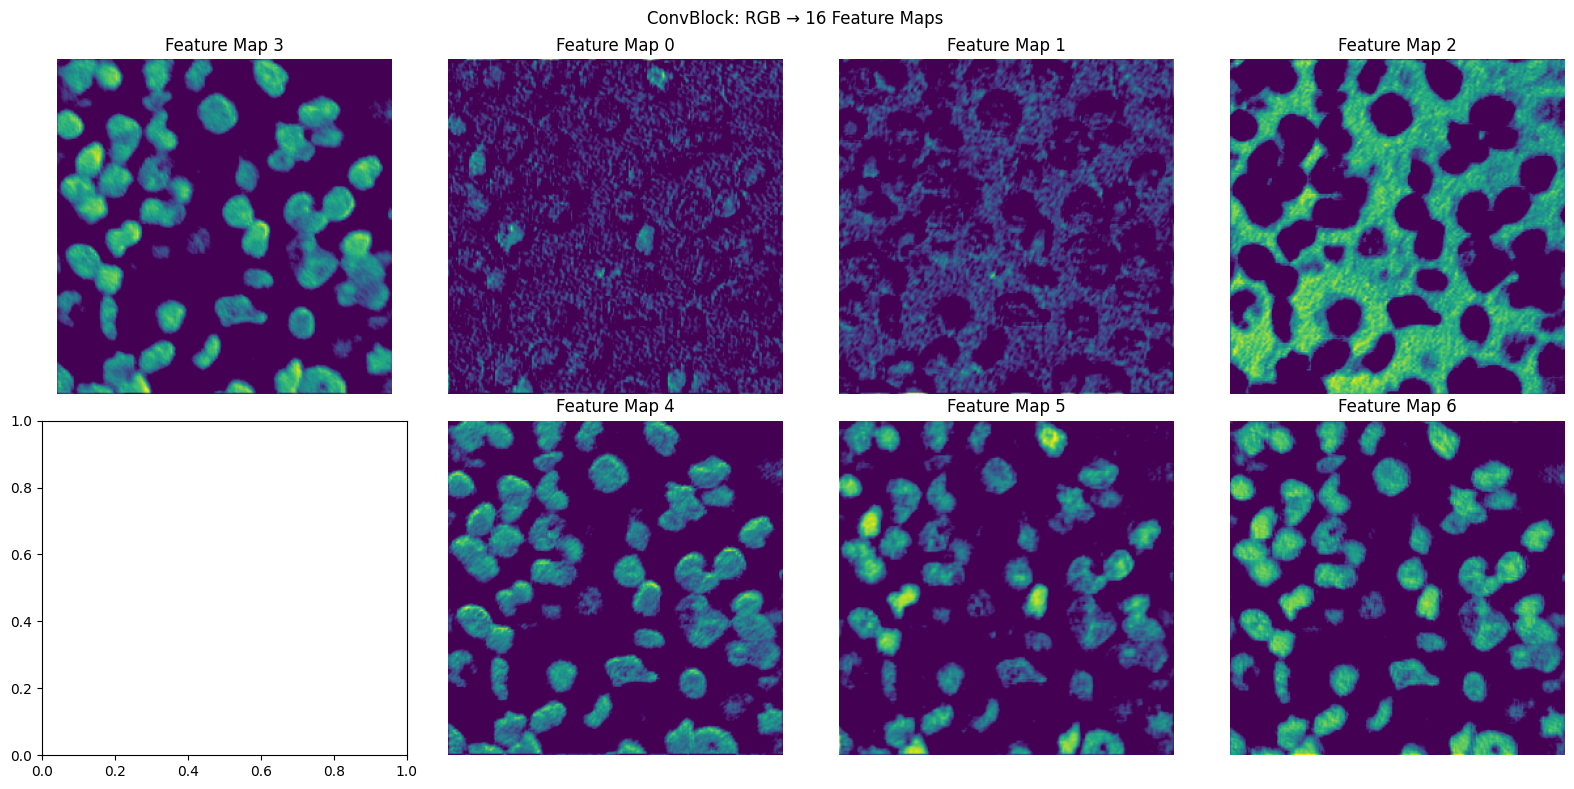

In [3]:
# Crear ConvBlock
conv_block = ConvBlock(in_channels=3, out_channels=16)
conv_block.eval()

with torch.no_grad():
    conv_output = conv_block(real_images)

print(f"ConvBlock: {conv_block}")
print(f"Input: {real_images.shape} → Output: {conv_output.shape}")
print(f"Parámetros: {sum(p.numel() for p in conv_block.parameters()):,}")

# Visualizar primeros feature maps
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Imagen original (primer canal)
axes[0, 0].imshow(real_images[0, 0].numpy(), cmap='gray')
axes[0, 0].set_title('Canal R Original')
axes[0, 0].axis('off')

# Feature maps generados
for i in range(7):
    row = i // 4
    col = (i + 1) % 4
    if row < 2 and col < 4:
        fm = conv_output[0, i].numpy()
        axes[row, col].imshow(fm, cmap='viridis')
        axes[row, col].set_title(f'Feature Map {i}')
        axes[row, col].axis('off')

plt.suptitle('ConvBlock: RGB → 16 Feature Maps')
plt.tight_layout()
plt.show()

## 3. Comparar DoubleConv vs ConvBlock Simple

Comparación ConvBlock vs DoubleConv:
Single: 1,856 parámetros
Double: 38,848 parámetros

Estadísticas de activación:
Single - Media: 0.183, Activación: 50.1%
Double - Media: 0.093, Activación: 59.7%


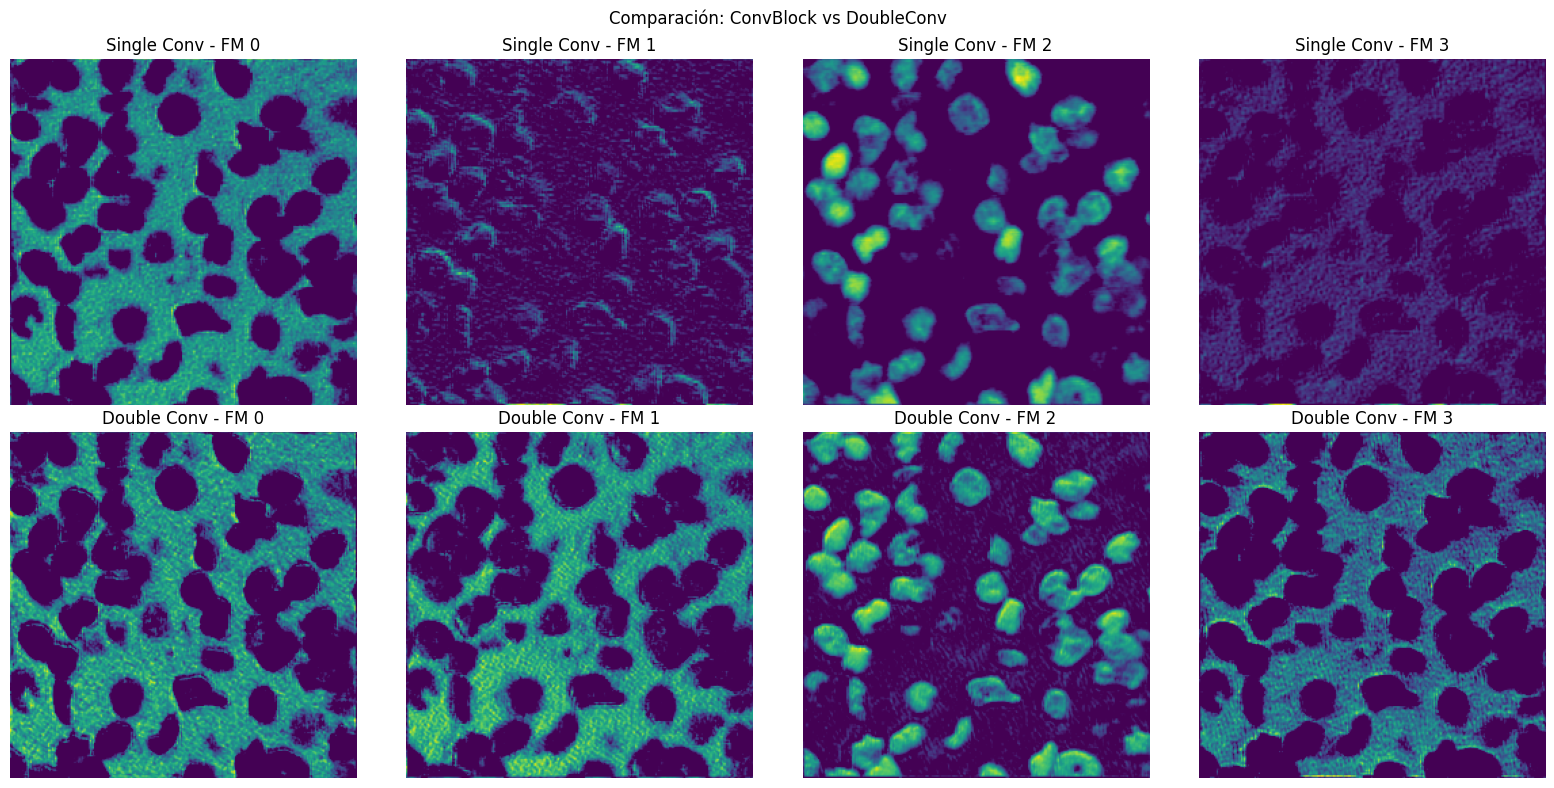

In [4]:
# Crear ambos bloques
single_conv = ConvBlock(in_channels=3, out_channels=64)
double_conv = DoubleConv(in_channels=3, out_channels=64)

single_conv.eval()
double_conv.eval()

with torch.no_grad():
    single_output = single_conv(real_images)
    double_output = double_conv(real_images)

print("Comparación ConvBlock vs DoubleConv:")
print(f"Single: {sum(p.numel() for p in single_conv.parameters()):,} parámetros")
print(f"Double: {sum(p.numel() for p in double_conv.parameters()):,} parámetros")

# Estadísticas
print(f"\nEstadísticas de activación:")
print(f"Single - Media: {single_output.mean():.3f}, Activación: {(single_output > 0).float().mean()*100:.1f}%")
print(f"Double - Media: {double_output.mean():.3f}, Activación: {(double_output > 0).float().mean()*100:.1f}%")

# Visualización comparativa
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    # ConvBlock simple
    axes[0, i].imshow(single_output[0, i].numpy(), cmap='viridis')
    axes[0, i].set_title(f'Single Conv - FM {i}')
    axes[0, i].axis('off')
    
    # DoubleConv
    axes[1, i].imshow(double_output[0, i].numpy(), cmap='viridis')
    axes[1, i].set_title(f'Double Conv - FM {i}')
    axes[1, i].axis('off')

plt.suptitle('Comparación: ConvBlock vs DoubleConv')
plt.tight_layout()
plt.show()

## 4. Simular Encoder Path (DownBlocks)

In [8]:
# Configuración encoder U-Net
encoder_blocks = [
    DoubleConv(3, 64),     # Nivel 1: sin downsampling
    DownBlock(64, 128),    # Nivel 2: 256→128
    DownBlock(128, 256),   # Nivel 3: 128→64
    DownBlock(256, 512),   # Nivel 4: 64→32
]

# Aplicar secuencialmente
x = real_images
encoder_outputs = []

print("Progresión del Encoder:")
print(f"Input: {x.shape}")

for i, block in enumerate(encoder_blocks):
    block.eval()
    with torch.no_grad():
        x = block(x)
    encoder_outputs.append(x)
    print(f"Nivel {i+1}: {x.shape}")

print(f"\nResoluciones: 256 → 256 → 128 → 64 → 32")
print(f"Canales: 3 → 64 → 128 → 256 → 512")

Progresión del Encoder:
Input: torch.Size([4, 3, 256, 256])
Nivel 1: torch.Size([4, 64, 256, 256])
Nivel 2: torch.Size([4, 128, 128, 128])
Nivel 3: torch.Size([4, 256, 64, 64])
Nivel 4: torch.Size([4, 512, 32, 32])

Resoluciones: 256 → 256 → 128 → 64 → 32
Canales: 3 → 64 → 128 → 256 → 512


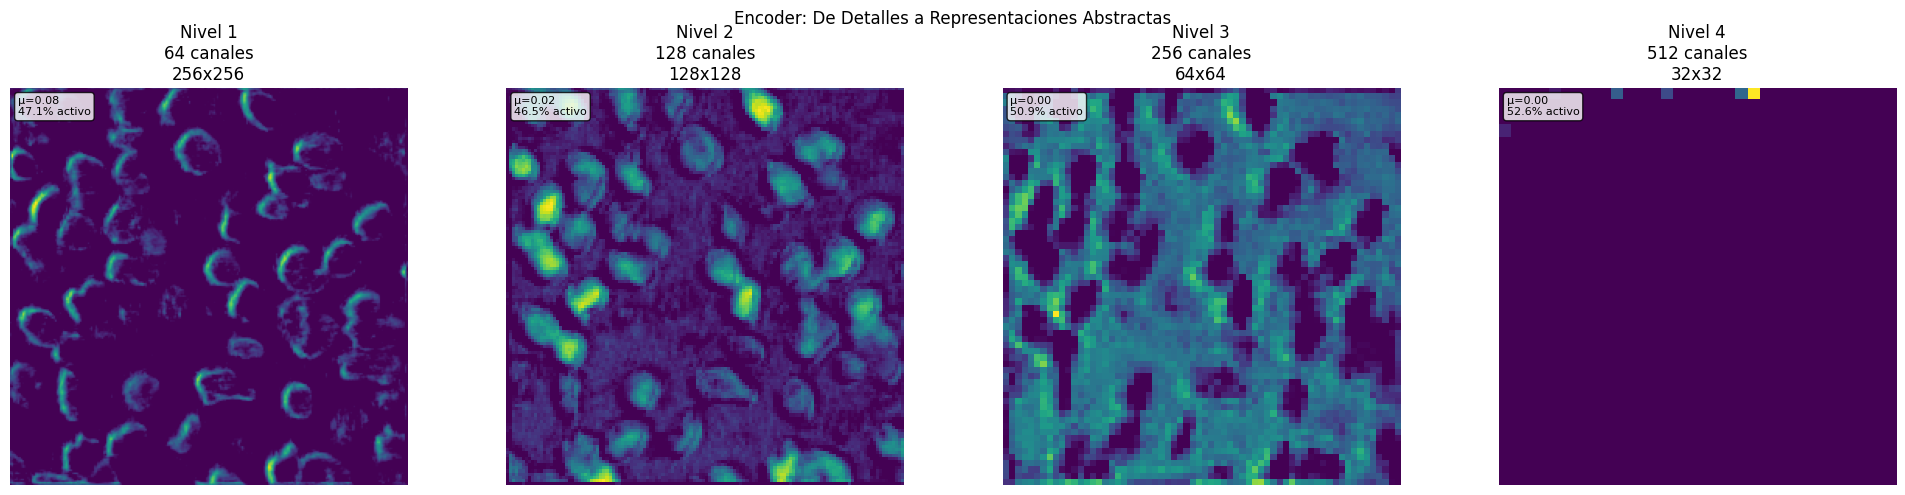

In [9]:
# Visualizar progresión encoder
fig, axes = plt.subplots(1, len(encoder_outputs), figsize=(20, 5))

for i, output in enumerate(encoder_outputs):
    # Mostrar primer feature map de cada nivel
    fm = output[0, 0].numpy()
    
    axes[i].imshow(fm, cmap='viridis')
    resolution = output.shape[-1]
    channels = output.shape[1]
    axes[i].set_title(f'Nivel {i+1}\n{channels} canales\n{resolution}x{resolution}')
    axes[i].axis('off')
    
    # Estadísticas
    mean_val = output.mean().item()
    sparsity = (output > 0).float().mean().item() * 100
    axes[i].text(0.02, 0.98, f'μ={mean_val:.2f}\n{sparsity:.1f}% activo', 
                transform=axes[i].transAxes, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=8)

plt.suptitle('Encoder: De Detalles a Representaciones Abstractas')
plt.tight_layout()
plt.show()

## 5. Simular Decoder Path (UpBlocks)

In [11]:
# Configuración decoder
decoder_blocks = [
    UpBlock(512, 256),  # ✅ CORRECTO
    UpBlock(256, 128),  # ✅ CORRECTO
    UpBlock(128, 64),   # ✅ CORRECTO
]

# Simular decoder con skip connections
x = encoder_outputs[-1]  # Bottom del encoder (512, 32, 32)
skip_connections = encoder_outputs[:-1][::-1]  # Invertir orden

print("Progresión del Decoder:")
print(f"Bottom input: {x.shape}")

decoder_outputs = []
for i, (block, skip) in enumerate(zip(decoder_blocks, skip_connections)):
    block.eval()
    with torch.no_grad():
        x = block(x, skip)
    decoder_outputs.append(x)
    print(f"Decoder {i+1}: {x.shape} (skip: {skip.shape})")

print(f"\nResoluciones decoder: 32 → 64 → 128 → 256")
print(f"Canales decoder: 512 → 256 → 128 → 64")

Progresión del Decoder:
Bottom input: torch.Size([4, 512, 32, 32])
Decoder 1: torch.Size([4, 256, 64, 64]) (skip: torch.Size([4, 256, 64, 64]))
Decoder 2: torch.Size([4, 128, 128, 128]) (skip: torch.Size([4, 128, 128, 128]))
Decoder 3: torch.Size([4, 64, 256, 256]) (skip: torch.Size([4, 64, 256, 256]))

Resoluciones decoder: 32 → 64 → 128 → 256
Canales decoder: 512 → 256 → 128 → 64


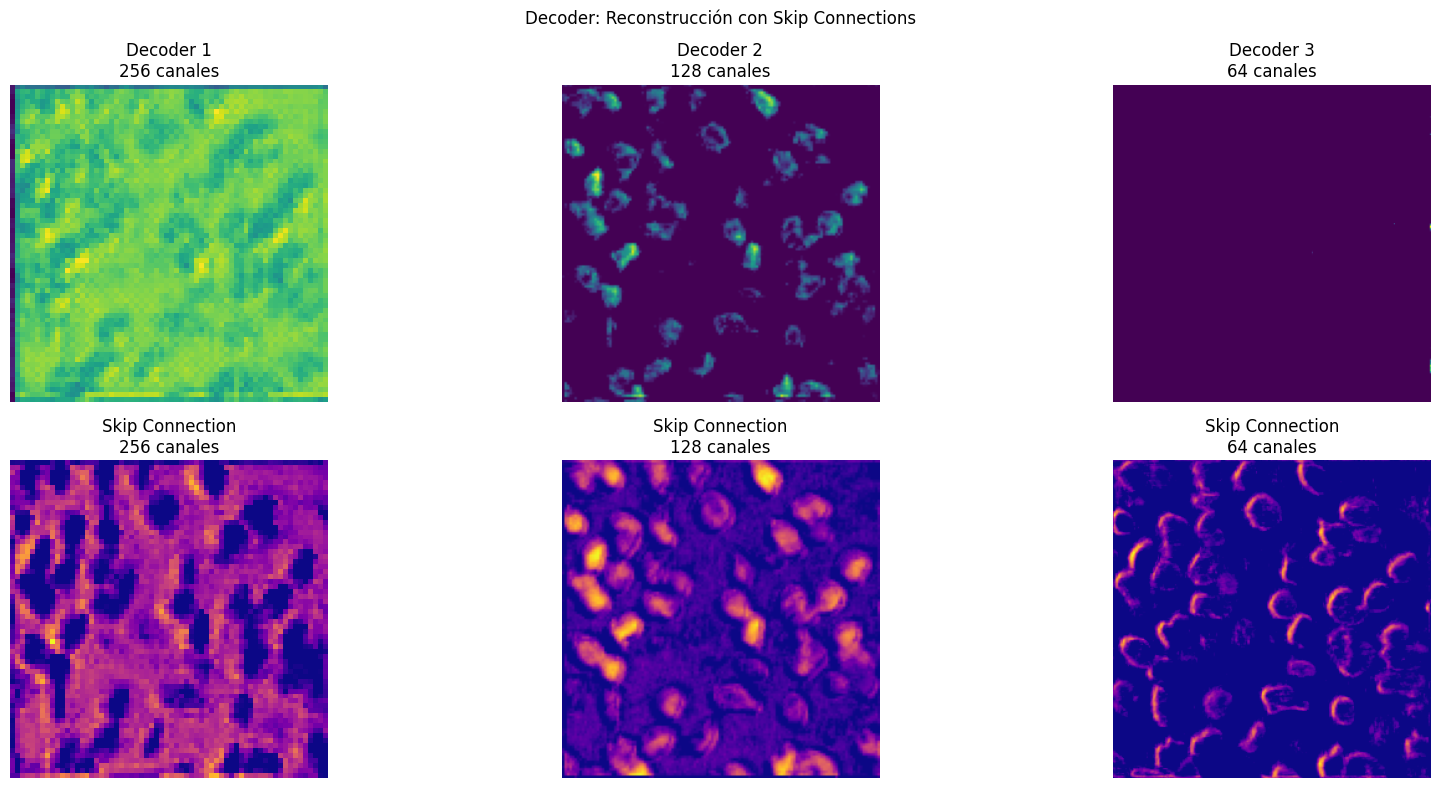

✅ Experimentación completada - Bloques listos para U-Net completa


In [12]:
# Visualizar progresión decoder
fig, axes = plt.subplots(2, len(decoder_outputs), figsize=(18, 8))

for i, (decoder_out, skip_in) in enumerate(zip(decoder_outputs, skip_connections)):
    # Decoder output
    fm_decoder = decoder_out[0, 0].numpy()
    axes[0, i].imshow(fm_decoder, cmap='viridis')
    axes[0, i].set_title(f'Decoder {i+1}\n{decoder_out.shape[1]} canales')
    axes[0, i].axis('off')
    
    # Skip connection
    fm_skip = skip_in[0, 0].numpy()
    axes[1, i].imshow(fm_skip, cmap='plasma')
    axes[1, i].set_title(f'Skip Connection\n{skip_in.shape[1]} canales')
    axes[1, i].axis('off')

plt.suptitle('Decoder: Reconstrucción con Skip Connections')
plt.tight_layout()
plt.show()

print("✅ Experimentación completada - Bloques listos para U-Net completa")